In [2]:
# 导入依赖包
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm

#忽略一些警告
import warnings
warnings.filterwarnings("ignore")


#可视化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

1、数据总览

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [5]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
#查看各列信息，主要看是否有缺失值
print("训练数据")
train.info()
#测试集数据查看
print("*"*40)
print("测试数据")
test.info()

训练数据
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 

In [9]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

2、数据分析

In [10]:
#数值型数据分析
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
# 相关性协方差表,corr()函数,返回结果接近0说明无相关性,大于0说明是正相关,小于0是负相关.
train_corr = train.drop('Id',axis=1).corr()
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


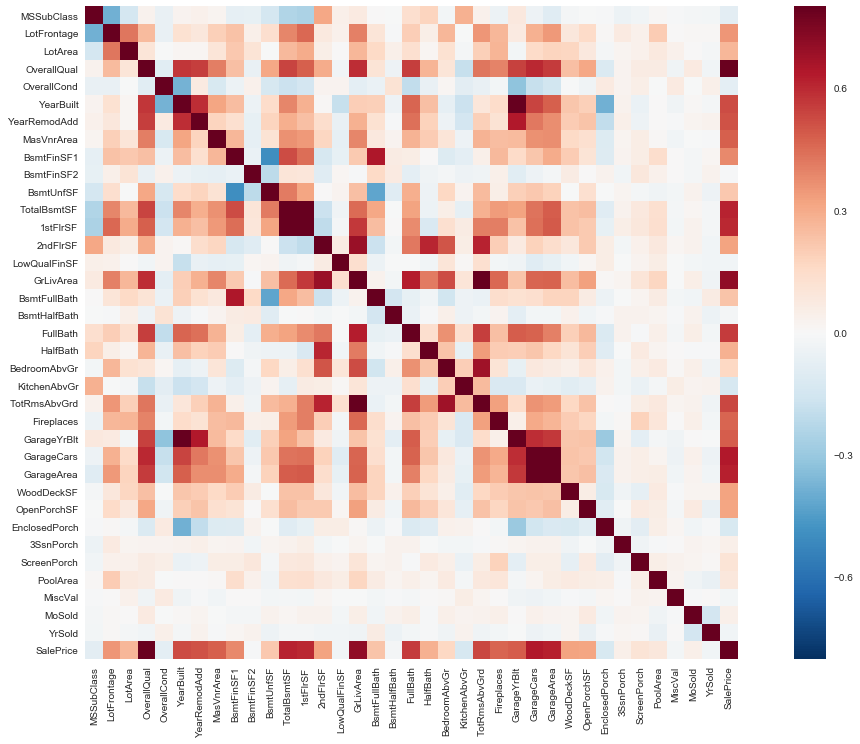

In [15]:
#画热力相关图
a = plt.subplots(figsize=(20,12)) #调整画布大小
a = sns.heatmap(train_corr,vmax=.8,square=True) #画热力图 annot=True 显示系数

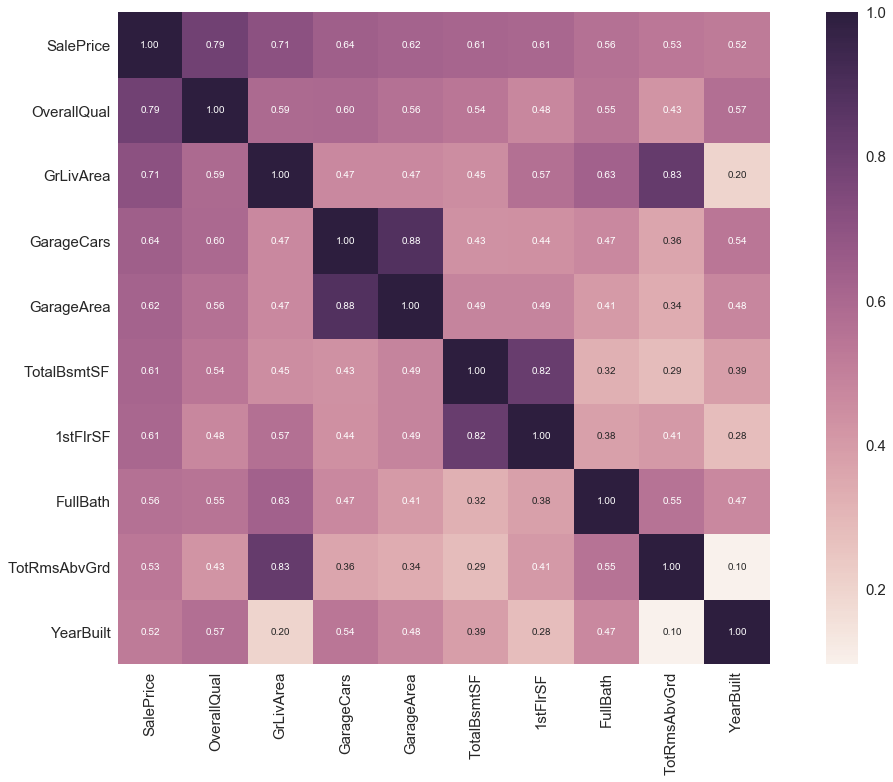

In [16]:
# 寻找K个最相关的特征信息
k = 10 # number of variables for heatmap
cols = train_corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
hm = plt.subplots(figsize=(20, 12))#调整画布大小
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
#分析乘客等级和生存下来的关系
train_df.groupby(['Pclass'])['Pclass','Survived'].mean()

,Pclass,Survived
Pclass,,
1,1.0,0.629630
2,2.0,0.472826
3,3.0,0.242363


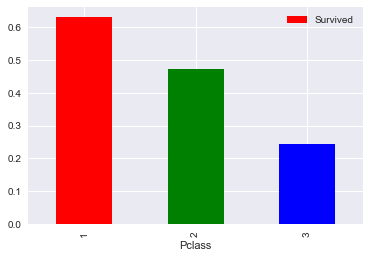

In [10]:
#分析乘客等级和生存下来的关系
train_df[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar(color=['r','g','b'])

In [11]:
#单独分析性别与生存下来的关系
train_df.groupby(['Sex'])['Sex','Survived'].mean()

,Survived
Sex,
female,0.742038
male,0.188908


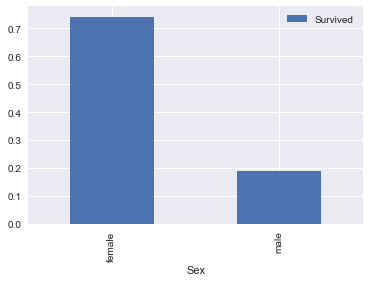

In [12]:
#单独分析性别与生存下来的关系
train_df[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

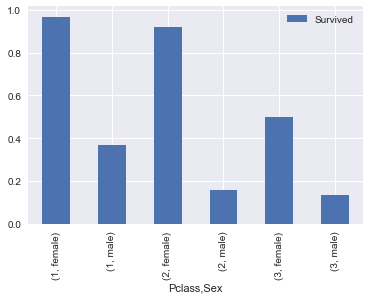

In [13]:
#性别和船舱等级与生存的关系
train_df[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

In [14]:
#性别和船舱等级与生存的关系
train_df.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

In [15]:
#分析兄弟配偶数量和生存下来的关系
train_df.groupby(['SibSp'])[['SibSp','Survived']].mean()

,SibSp,Survived
SibSp,,
0,0.0,0.345395
1,1.0,0.535885
2,2.0,0.464286
3,3.0,0.250000
4,4.0,0.166667
5,5.0,0.000000
8,8.0,0.000000


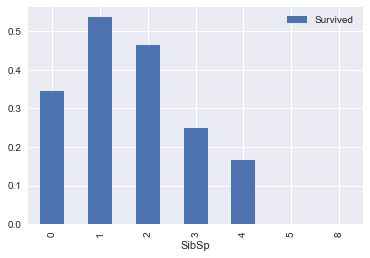

In [16]:
#分析兄弟配偶数量和生存下来的关系
train_df[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar()

In [17]:
#分析父母子女数量和生存下来的关系
train_df.groupby('Parch')[['Parch','Survived']].mean()

,Parch,Survived
Parch,,
0,0.0,0.343658
1,1.0,0.550847
2,2.0,0.500000
3,3.0,0.600000
4,4.0,0.000000
5,5.0,0.200000
6,6.0,0.000000


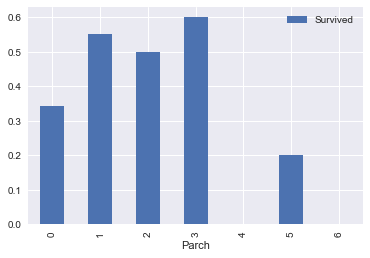

In [18]:
#分析父母子女数量和生存下来的关系
train_df[['Parch','Survived']].groupby(['Parch']).mean().plot.bar()

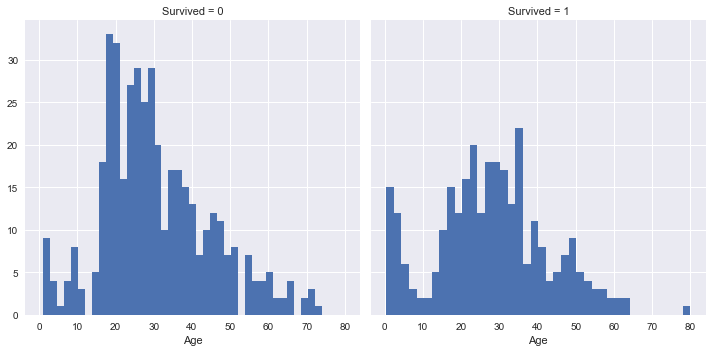

In [19]:
#分析年龄和生存下来的关系，年龄有缺失值
g = sns.FacetGrid(train_df,col='Survived',size=5)
g.map(plt.hist,'Age',bins=40)

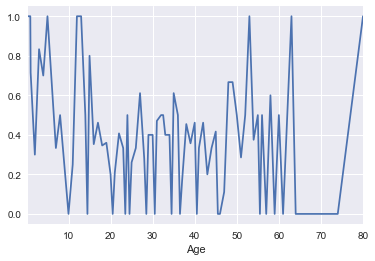

In [20]:
train_df.groupby(['Age'])['Survived'].mean().plot()

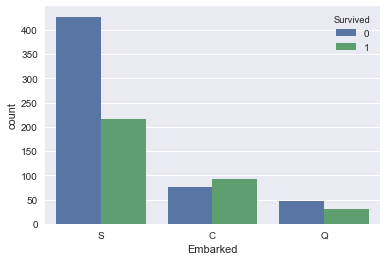

In [21]:
#登陆港口和生存的关系
sns.countplot('Embarked',hue='Survived',data=train_df)

3、特征工程

In [22]:
#先将数据集合并,一起做特征工程(注意,标准化的时候需要分开处理)
#先将test补齐,然后通过pd.apped()合并
test_df['Survived'] = 0
train_test = train_df.append(test_df)

In [23]:
train_test.shape
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [24]:
#利用get_dummies函数进行Pclass独热处理
train_test = pd.get_dummies(train_test,columns=['Pclass'])
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,male,1,0,A/5 21171,0,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,female,1,1,PC 17599,1,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282,0,0,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,female,1,1,113803,1,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,male,0,0,373450,0,0,1


In [25]:
#对sex分裂处理
train_test = pd.get_dummies(train_test,columns=["Sex"])
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,0,1,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,PC 17599,1,0,0,1,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,0,1,STON/O2. 3101282,0,0,1,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,113803,1,0,0,1,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,0,0,373450,0,0,1,0,1


In [26]:
train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,0,1,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,PC 17599,1,0,0,1,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,0,1,STON/O2. 3101282,0,0,1,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,113803,1,0,0,1,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,0,0,373450,0,0,1,0,1


In [27]:
#对兄弟姐妹以及父母子女进行处理
train_test['SibSp_Parch'] = train_test['SibSp']+train_test['Parch']
train_test = pd.get_dummies(train_test,columns=['SibSp','Parch','SibSp_Parch'])
train_test.head()

,Age,Cabin,Embarked,Fare,Name,PassengerId,Survived,Ticket,Pclass_1,Pclass_2,...,Parch_9,SibSp_Parch_0,SibSp_Parch_1,SibSp_Parch_2,SibSp_Parch_3,SibSp_Parch_4,SibSp_Parch_5,SibSp_Parch_6,SibSp_Parch_7,SibSp_Parch_10
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,0,...,0,0,1,0,0,0,0,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,1,PC 17599,1,0,...,0,0,1,0,0,0,0,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",3,1,STON/O2. 3101282,0,0,...,0,1,0,0,0,0,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1,113803,1,0,...,0,0,1,0,0,0,0,0,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",5,0,373450,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
#train_test.info()
#对Embarked进行处理
train_test = pd.get_dummies(train_test,columns=["Embarked"])
train_test.head()

,Age,Cabin,Fare,Name,PassengerId,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3,...,SibSp_Parch_2,SibSp_Parch_3,SibSp_Parch_4,SibSp_Parch_5,SibSp_Parch_6,SibSp_Parch_7,SibSp_Parch_10,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,1,PC 17599,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",3,1,STON/O2. 3101282,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1,113803,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",5,0,373450,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [29]:
#对Name进行处理
train_test['Name1']=train_test['Name'].str.extract('.+,(.+)',expand=False).str.extract('^(.+?)\.',expand=False).str.strip()
#train_test['Name1']

In [30]:
#将姓名分类处理()
train_test['Name1'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer' , inplace = True)
train_test['Name1'].replace(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty' , inplace = True)
train_test['Name1'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs')
train_test['Name1'].replace(['Mlle', 'Miss'], 'Miss')
train_test['Name1'].replace(['Mr'], 'Mr' , inplace = True)
train_test['Name1'].replace(['Master'], 'Master' , inplace = True)
#train_test['Name1']

In [31]:
train_test=pd.get_dummies(train_test,columns=["Name1"])
#train_test.head()

In [32]:
#从姓名中提取出姓
train_test['Name2'] = train_test['Name'].apply(lambda x: x.split('.')[1])

# #计算数量,然后合并数据集
Name2_sum = train_test['Name2'].value_counts().reset_index()
Name2_sum.columns=['Name2','Name2_sum']
train_test = pd.merge(train_test,Name2_sum,how='left',on='Name2')

#由于出现一次时该特征时无效特征,用one来代替出现一次的姓
train_test.loc[train_test['Name2_sum'] == 1 , 'Name2_new'] = 'one'
train_test.loc[train_test['Name2_sum'] > 1 , 'Name2_new'] = train_test['Name2']
del train_test['Name2']

# #分列处理
train_test = pd.get_dummies(train_test,columns=['Name2_new'])
#删掉姓名这个特征
del train_test['Name']

#train_test.head()

In [33]:
#处理Fare变量
train_test.loc[train_test["Fare"].isnull()]

,Age,Cabin,Fare,PassengerId,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Name2_new_ Thomas Henry,Name2_new_ Victor,Name2_new_ Washington,Name2_new_ William,Name2_new_ William Edward,Name2_new_ William Henry,Name2_new_ William James,Name2_new_ William John,Name2_new_ William Thomas,Name2_new_one
1043,60.5,NaN,NaN,1044,0,3701,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#处理Fare变量，由于变量和Pclass以及Embarked有关
train_df.groupby(by=["Pclass","Embarked"]).Fare.mean()

Pclass  Embarked
1       C           104.718529
        Q            90.000000
        S            70.364862
2       C            25.358335
        Q            12.350000
        S            20.327439
3       C            11.214083
        Q            11.183393
        S            14.644083
Name: Fare, dtype: float64

In [35]:
#用pclass=3和Embarked=S的平均数14.644083来替换
train_test['Fare'].fillna(14.644083,inplace=True)
train_test.loc(train_test['Fare'].isnull())

In [36]:
#将Ticket提取字符列
#str.isnumeric()  如果S中只有数字字符，则返回True，否则返回False
train_test['Ticket']
train_test['Ticket_Letter'] = train_test['Ticket'].str.split().str[0]

In [37]:
train_test['Ticket_Letter'] = train_test['Ticket_Letter'].apply(lambda x:np.nan if x.isnumeric() else x)
train_test.drop('Ticket',inplace=True,axis=1)

In [38]:
#分列,此时nan值可以不做处理
train_test = pd.get_dummies(train_test,columns=['Ticket_Letter'],drop_first=True)
#train_test.head()

In [39]:
#Age
train_test.loc[train_test['Age'].isnull()]

,Age,Cabin,Fare,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Ticket_Letter_SOTON/O2,Ticket_Letter_SOTON/OQ,Ticket_Letter_STON/O,Ticket_Letter_STON/O2.,Ticket_Letter_STON/OQ.,Ticket_Letter_SW/PP,Ticket_Letter_W./C.,Ticket_Letter_W.E.P.,Ticket_Letter_W/C,Ticket_Letter_WE/P
5,NaN,NaN,8.4583,6,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
17,NaN,NaN,13.0000,18,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19,NaN,NaN,7.2250,20,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
26,NaN,NaN,7.2250,27,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
28,NaN,NaN,7.8792,29,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
29,NaN,NaN,7.8958,30,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
31,NaN,B78,146.5208,32,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
32,NaN,NaN,7.7500,33,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
36,NaN,NaN,7.2292,37,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
42,NaN,NaN,7.8958,43,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
"""这是模型就好后回来增加的新特征
考虑年龄缺失值可能影响死亡情况,数据表明,年龄缺失的死亡率为0.19."""
train_test.loc[train_test["Age"].isnull()]['Survived'].mean()

0.19771863117870722

In [41]:
#利用年龄是否缺失来构造新特征
train_test.loc[train_test["Age"].isnull(),"age_nan"]=1
train_test.loc[train_test["Age"].notnull(),"age_nan"]=0
train_test=pd.get_dummies(train_test,columns=["age_nan"])

In [42]:
#创建没有["Age"，"Survived"]的数据集
missing_age = train_test.drop(['Survived','Cabin'],axis=1)
#将Age完整的项作为训练集、将Age缺失的项作为测试集。
missing_age_train = missing_age[missing_age['Age'].notnull()]
missing_age_test = missing_age[missing_age['Age'].isnull()]

In [43]:
#构建训练集合预测集的X和Y值
missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
missing_age_Y_train = missing_age_train['Age']
missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

In [44]:
# 先将数据标准化
ss = StandardScaler()
#用测试集训练并标准化
ss.fit(missing_age_X_train)
missing_age_X_train = ss.transform(missing_age_X_train)
missing_age_X_test = ss.transform(missing_age_X_test)

In [45]:
#使用贝叶斯岭回归预测年龄
lin = BayesianRidge()

In [46]:
lin.fit(missing_age_X_train,missing_age_Y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [47]:
#利用loc将预测值填入数据集
train_test.loc[(train_test['Age'].isnull()), 'Age'] = lin.predict(missing_age_X_test)

In [48]:
#将年龄划分是个阶段10以下,10-18,18-30,30-50,50以上
train_test['Age'] = pd.cut(train_test['Age'], bins=[0,10,18,30,50,100],labels=[1,2,3,4,5])

train_test = pd.get_dummies(train_test,columns=['Age'])

In [49]:
train_test.head()

,Cabin,Fare,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,...,Ticket_Letter_W.E.P.,Ticket_Letter_W/C,Ticket_Letter_WE/P,age_nan_0.0,age_nan_1.0,Age_1,Age_2,Age_3,Age_4,Age_5
0,NaN,7.2500,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,C85,71.2833,2,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,NaN,7.9250,3,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0
3,C123,53.1000,4,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,NaN,8.0500,5,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0


In [50]:
#cabin项缺失太多，只能将有无Cain首字母进行分类,缺失值为一类,作为特征值进行建模
train_test['Cabin_nan'] = train_test['Cabin'].apply(lambda x:str(x)[0] if pd.notnull(x) else x)
train_test = pd.get_dummies(train_test,columns=['Cabin_nan'])

In [51]:
 #cabin项缺失太多，只能将有无Cain首字母进行分类,
train_test.loc[train_test["Cabin"].isnull() ,"Cabin_nan"] = 1
train_test.loc[train_test["Cabin"].notnull() ,"Cabin_nan"] = 0
train_test = pd.get_dummies(train_test,columns=['Cabin_nan'])
train_test.drop('Cabin',axis=1,inplace=True)

In [52]:
train_test.head()

,Fare,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Cabin_nan_A,Cabin_nan_B,Cabin_nan_C,Cabin_nan_D,Cabin_nan_E,Cabin_nan_F,Cabin_nan_G,Cabin_nan_T,Cabin_nan_0.0,Cabin_nan_1.0
0,7.2500,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,71.2833,2,1,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,7.9250,3,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,53.1000,4,1,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,8.0500,5,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
#特征工程完毕，划分数据集
train_data = train_test[:891]
test_data = train_test[891:]
train_data_X = train_data.drop(['Survived'],axis=1)
train_data_Y = train_data['Survived']
test_data_X = test_data.drop(['Survived'],axis=1)

In [54]:
print(train_data_X.shape)

(891, 199)


In [55]:
# 标准化
ss2 = StandardScaler()
ss2.fit(train_data_X)
train_data_X_sd = ss2.transform(train_data_X)
test_data_X_sd = ss2.transform(test_data_X)

4、建立基模型

In [56]:
#Logistic

#划分训练集和测试集
train_data,dev_data,train_label,dev_label = train_test_split(train_data_X_sd,train_data_Y,test_size=0.1,random_state=34)

lr1=LogisticRegression()
param={'C':[0.001,0.01,0.1,1,10],"max_iter":[100,250]}
clf = GridSearchCV(lr1,param,cv=5)
clf.fit(train_data,train_label)

#打印结果
print(clf.grid_scores_)
print(clf.best_params_)

#将最佳参数输入模型
lr = LogisticRegression(C=0.01,max_iter=100)
lr.fit(train_data, train_label)

print(lr.score(dev_data,dev_label))
# 输出结果
test_df["Survived"] = lr.predict(test_data_X_sd)
test_df[["PassengerId","Survived"]].set_index("PassengerId").to_csv('../out/LR.csv')

[mean: 0.78652, std: 0.03106, params: {'C': 0.001, 'max_iter': 100}, mean: 0.78652, std: 0.03106, params: {'C': 0.001, 'max_iter': 250}, mean: 0.79026, std: 0.02927, params: {'C': 0.01, 'max_iter': 100}, mean: 0.79026, std: 0.02927, params: {'C': 0.01, 'max_iter': 250}, mean: 0.78527, std: 0.03109, params: {'C': 0.1, 'max_iter': 100}, mean: 0.78527, std: 0.03109, params: {'C': 0.1, 'max_iter': 250}, mean: 0.78652, std: 0.03641, params: {'C': 1, 'max_iter': 100}, mean: 0.78652, std: 0.03641, params: {'C': 1, 'max_iter': 250}, mean: 0.78402, std: 0.04035, params: {'C': 10, 'max_iter': 100}, mean: 0.78402, std: 0.04035, params: {'C': 10, 'max_iter': 250}]
{'C': 0.01, 'max_iter': 100}
0.8555555555555555


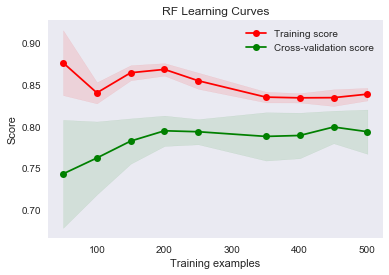

In [57]:
#模型验证

#该函数用来绘制score学习曲线，参见sklearn example
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    #fill_between用来填充不同曲线周边的颜色
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    #绘制训练得分
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    #训练验证得分
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "RF Learning Curves"
rf = RandomForestClassifier(n_estimators=500,min_samples_leaf=3,max_depth=6,oob_score=True)
plot_learning_curve(rf, title, train_data_X,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [58]:
# 随机森林
rf = RandomForestClassifier(n_estimators=500,min_samples_leaf=3,max_depth=6,oob_score=True)
rf.fit(train_data_X,train_data_Y)
print(rf.oob_score_)
test_df["Survived"] = rf.predict(test_data_X)
RF = test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/RF_n150.csv')

#输出交叉验证得分
print(cross_val_score(rf,train_data_X_sd,train_data_Y,cv=5))
print(cross_val_score(rf,train_data_X_sd,train_data_Y,cv=5).mean())
# # 保存模型
# from sklearn.externals import joblib
# joblib.dump(rf, '../model/rf10.pkl')

0.8226711560044894


[0.7877095  0.80446927 0.78651685 0.78089888 0.85875706]
0.8036703126867384


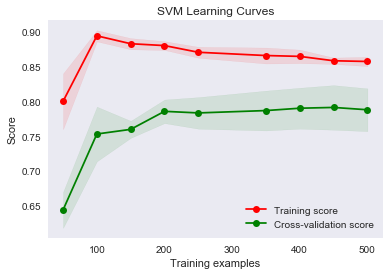

In [76]:
#svm算法
svc = SVC()
svc.fit(train_data_X_sd,train_data_Y)
#预测保存数据
test_df["Survived"]=svc.predict(test_data_X_sd)
test_df[["PassengerId","Survived"]].set_index("PassengerId").to_csv('../out/SVM.csv')

from sklearn.model_selection import cross_val_score
#输出交叉验证得分
print(cross_val_score(svc,train_data_X_sd,train_data_Y,cv=5))
print(cross_val_score(svc,train_data_X_sd,train_data_Y,cv=5).mean())

title = "SVM Learning Curves"
plot_learning_curve(svc, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

[0.61452514 0.7877095  0.87078652 0.79775281 0.83615819]
0.7824974723268106


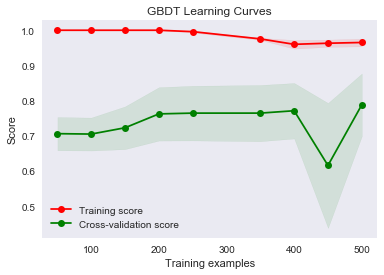

In [77]:
#GBDT

gbdt = GradientBoostingClassifier(learning_rate=0.01,max_depth=6,n_estimators=500,min_samples_leaf=3)
gbdt.fit(train_data_X,train_data_Y)

test_df["Survived"] = gbdt.predict(test_data_X)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/GBDT.csv')

print(cross_val_score(gbdt,train_data_X,train_data_Y,cv=5))
print(cross_val_score(gbdt,train_data_X,train_data_Y,cv=5).mean())

title = "GBDT Learning Curves"
plot_learning_curve(gbdt, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

[0.62011173 0.79329609 0.84831461 0.82022472 0.84745763]
0.7858809548380782


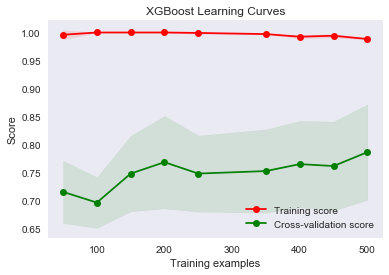

In [ ]:
#XGBoost

xgb_model = xgb.XGBClassifier(n_estimators=150,min_samples_leaf=3,max_depth=6)
xgb_model.fit(train_data_X,train_data_Y)

test_df["Survived"] = xgb_model.predict(test_data_X)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/XGB.csv')

print(cross_val_score(xgb_model,train_data_X,train_data_Y,cv=5))
print(cross_val_score(xgb_model,train_data_X,train_data_Y,cv=5).mean())

title = "XGBoost Learning Curves"
plot_learning_curve(xgb_model, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [ ]:
xgb_model = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(train_data_X,train_data_Y)

test_df["Survived"] = xgb_model.predict(test_data_X)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/xgb.csv')

print(cross_val_score(xgb_model,train_data_X,train_data_Y,cv=5))
print(cross_val_score(xgb_model,train_data_X,train_data_Y,cv=5).mean())

title = "XGBoost Learning Curves"
plot_learning_curve(xgb_model, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

[0.69832402 0.79888268 0.86516854 0.81460674 0.85875706]
0.8071478093912766


5、模型融合

In [ ]:
#模型Voting

lr = LogisticRegression(C=0.1,max_iter=100)
xgb_model = xgb.XGBClassifier(max_depth=6,min_samples_leaf=2,n_estimators=100)
rf = RandomForestClassifier(n_estimators=200,min_samples_leaf=2,max_depth=6,oob_score=True)
gbdt = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=2,max_depth=6,n_estimators=100)

vot = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gbdt',gbdt),('xgb',xgb_model)], voting='hard')
vot.fit(train_data_X_sd,train_data_Y)

test_df["Survived"] = vot.predict(test_data_X_sd)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/VOT.csv')

#输出交叉验证得分
print(cross_val_score(vot,train_data_X_sd,train_data_Y,cv=5))
print(cross_val_score(vot,train_data_X_sd,train_data_Y,cv=5).mean())

title = "Voting Learning Curves"
plot_learning_curve(vot, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [64]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier


vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', AdaBoostClassifier()),
    ('bc', BaggingClassifier()),
    ('etc',ExtraTreesClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', LogisticRegression()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', xgb.XGBClassifier(learning_rate=0.1, max_depth=2, 
silent=True, objective='binary:logistic'))

]


#Hard Vote or majority rules
vote_hard = VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = cross_val_score(vote_hard, train_data_X_sd, train_data_Y, cv=5)
vote_hard.fit(train_data_X_sd,train_data_Y)

print(vote_hard_cv.mean()) 
print('-'*10)

#Soft Vote or weighted probabilities
vote_soft = VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = cross_val_score(vote_soft, train_data_X_sd,train_data_Y,cv=5)
vote_soft.fit(train_data_X_sd,train_data_Y)

print(vote_soft_cv.mean()) 
print('-'*10)

test_df["Survived"] = vote_hard.predict(test_data_X_sd)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/Vot_hard.csv')

test_df["Survived"] = vote_soft.predict(test_data_X_sd)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/Vot_soft.csv')

0.8070849677652958
----------
0.8115606604328626
----------


In [ ]:
#模型stacking
# 划分train数据集,调用代码,把数据集名字转成和代码一样
X = train_data_X_sd
X_predict = test_data_X_sd
y = train_data_Y

'''模型融合中使用到的各个单模型'''
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

clfs = [LogisticRegression(C=0.01,max_iter=100),
        xgb.XGBClassifier(max_depth=6,n_estimators=100,num_round = 5),
        RandomForestClassifier(n_estimators=200,max_depth=6,oob_score=True),
        GradientBoostingClassifier(learning_rate=0.3,max_depth=6,n_estimators=100)]

# 创建n_folds
from sklearn.model_selection import StratifiedKFold
n_folds = 5
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X,y)
# 创建零矩阵
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

# 建立模型
for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    # print(j, clf)
    dataset_blend_test_j = np.zeros((X_predict.shape[0], skf.get_n_splits(X,y)))
    i=0;
    for train_index, test_index in skf.split(X,y):
        '''使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。'''
        X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test_index, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
        i+=1
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

# 用建立第二层模型
clf2 = LogisticRegression(C=0.01,max_iter=100)
clf2.fit(dataset_blend_train, y)
# y_submission = clf2.predict_proba(dataset_blend_test)[:, 1]


test_df["Survived"] = clf2.predict(dataset_blend_test)
test_df[['PassengerId','Survived']].set_index('PassengerId').to_csv('../out/Stack.csv')

#输出交叉验证得分
print(cross_val_score(clf2,dataset_blend_train,y,cv=5))

title = "Stacking Learning Curves"
plot_learning_curve(clf2, title, train_data_X_sd,train_data_Y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()